In [1]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Conv1D, Multiply, Permute, BatchNormalization, MaxPool1D, TimeDistributed, RepeatVector, Lambda, Bidirectional
from tensorflow.keras import backend as K
from tensorflow.keras import callbacks as kcallbacks
from sklearn.model_selection import train_test_split

In [2]:
def attention_3d_block(inputs, single_attention_vector=False):
    time_steps = K.int_shape(inputs)[1]
    input_dim = K.int_shape(inputs)[2]
    a = Permute((2, 1))(inputs)
    a = Dense(time_steps, activation='softmax')(a)
    if single_attention_vector:
        a = Lambda(lambda x: K.mean(x, axis=1))(a)
        a = RepeatVector(input_dim)(a)
    a_probs = Permute((2, 1))(a)
    output_attention_mul = Multiply()([inputs, a_probs])
    return output_attention_mul

In [3]:
def attention_model(n_classes):
    inputs = Input(shape=(152, 7))
    x = BatchNormalization()(inputs)
    x = Conv1D(filters=32, kernel_size=1, padding="same", kernel_initializer='he_normal', bias_initializer='zeros', activation='relu')(x)
    x = MaxPool1D()(x)
    lstm_out = Bidirectional(LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))(x)
    lstm_out = Bidirectional(LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))(lstm_out)
    # print(K.int_shape(lstm_out))
    attention_mul = attention_3d_block(lstm_out)
    attention_mul = TimeDistributed(Dense(n_classes, activation='softmax'))(attention_mul)
    model = Model(inputs=[inputs], outputs=attention_mul)
    return model

In [11]:
# Load and process your data
gabor_features = np.load('data.npy')  # data
sequences = np.load('label.npy')  # labels

In [12]:
gabor_features.shape

(1258, 152, 7)

In [14]:
gabor_features[0]

array([[ 3.20000000e+01,  5.00000000e+00,  8.70000000e+01, ...,
         7.63218391e+00,  1.97460000e+04, -1.53666249e+00],
       [ 2.40000000e+01,  6.00000000e+00,  1.10000000e+02, ...,
         8.42727273e+00,  2.11650000e+04, -1.52552821e+00],
       [ 2.30000000e+01,  6.00000000e+00,  1.02000000e+02, ...,
         8.65686275e+00,  2.04510000e+04, -1.54450937e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [13]:
sequences.shape

(1256,)

In [15]:
sequences[0]

"Text:  WHEN YOU'RE COOKING CHIPS AT HOME"

In [20]:
def load_and_process_data(gabor_features, sequences):
    # Convert text sequences to numeric
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(sequences)
    sequences_numeric = tokenizer.texts_to_sequences(sequences)
    print(sequences_numeric[0])
    # print(tokenizer.word_index)

    # Convert sequences to categorical
    sequences_categorical = [to_categorical(seq, num_classes=len(tokenizer.word_index) + 1) for seq in sequences_numeric]
    # print(sequences_categorical[0])

    # Pad the sequences and targets
    gabor_features_padded = pad_sequences(gabor_features, dtype='float32', padding='post')
    print(gabor_features_padded[0])
    sequences_padded = pad_sequences(sequences_categorical, maxlen=76, dtype='float32', padding='post', truncating='post')
    print(sequences_padded[0])

    return gabor_features_padded, sequences_padded, len(tokenizer.word_index) + 1

In [21]:
# Load and process your data
gabor_features, sequences_padded, n_classes = load_and_process_data(gabor_features, sequences)
print(f"Number of classes: {n_classes}")

# Check lengths of data
if len(gabor_features) != len(sequences_padded):
    print(f"Length of input data: {len(gabor_features)}, Length of output data: {len(sequences_padded)}")
    # Trim the larger dataset
    min_len = min(len(gabor_features), len(sequences_padded))
    gabor_features = gabor_features[:min_len]
    sequences_padded = sequences_padded[:min_len]

[1, 45, 105, 457, 458, 26, 96]
{'text': 1, 'the': 2, 'a': 3, 'to': 4, 'and': 5, 'of': 6, 'i': 7, 'you': 8, 'in': 9, 'is': 10, 'that': 11, 'it': 12, 'was': 13, 'but': 14, 'we': 15, 'they': 16, 'on': 17, 'for': 18, 'have': 19, 'with': 20, 'this': 21, 'be': 22, 'not': 23, 'if': 24, 'are': 25, 'at': 26, 'as': 27, "it's": 28, 'about': 29, 'what': 30, 'like': 31, 'do': 32, 'think': 33, 'which': 34, 'because': 35, 'all': 36, 'one': 37, "i'm": 38, 'would': 39, 'my': 40, 'there': 41, 'from': 42, 'out': 43, 'very': 44, 'when': 45, "that's": 46, 'people': 47, 'so': 48, 'them': 49, 'he': 50, 'really': 51, 'or': 52, 'up': 53, 'get': 54, 'an': 55, 'she': 56, 'had': 57, 'now': 58, 'here': 59, 'your': 60, 'by': 61, 'been': 62, 'some': 63, 'know': 64, 'can': 65, 'how': 66, "don't": 67, 'us': 68, 'going': 69, 'their': 70, 'more': 71, 'has': 72, 'just': 73, 'well': 74, 'time': 75, 'got': 76, 'much': 77, 'something': 78, 'go': 79, 'property': 80, 'could': 81, 'were': 82, 'over': 83, 'off': 84, 'good': 85,

In [18]:
gabor_features.shape

(1256, 152, 7)

In [19]:
sequences_padded.shape

(1256, 76, 2220)

In [6]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(gabor_features, sequences_padded, test_size=0.2)

# Create and compile model
model = attention_model(n_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Set callbacks
lr_reduce = kcallbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, verbose=1, min_lr=0.00001)
save_model = kcallbacks.ModelCheckpoint(filepath="model/lrs2_gabor_seq2seq.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [9]:
# Train the model
history = model.fit(x=X_train, y=y_train, batch_size=128, epochs=50, validation_data=(X_test, y_test), callbacks=[lr_reduce, save_model])

Epoch 1/50
8/8 [==============================] - ETA: 0s - loss: 0.6976 - accuracy: 0.0160
Epoch 1: val_accuracy improved from 0.01566 to 0.01624, saving model to model\lrs2_gabor_seq2seq.h5
8/8 [==============================] - 23s 3s/step - loss: 0.6976 - accuracy: 0.0160 - val_loss: 0.7168 - val_accuracy: 0.0162 - lr: 0.0010
Epoch 2/50
8/8 [==============================] - ETA: 0s - loss: 0.6862 - accuracy: 0.0165
Epoch 2: val_accuracy improved from 0.01624 to 0.01666, saving model to model\lrs2_gabor_seq2seq.h5
8/8 [==============================] - 29s 4s/step - loss: 0.6862 - accuracy: 0.0165 - val_loss: 0.7092 - val_accuracy: 0.0167 - lr: 0.0010
Epoch 3/50
8/8 [==============================] - ETA: 0s - loss: 0.6768 - accuracy: 0.0169
Epoch 3: val_accuracy improved from 0.01666 to 0.01671, saving model to model\lrs2_gabor_seq2seq.h5
8/8 [==============================] - 29s 4s/step - loss: 0.6768 - accuracy: 0.0169 - val_loss: 0.7036 - val_accuracy: 0.0167 - lr: 0.0010
Epoc

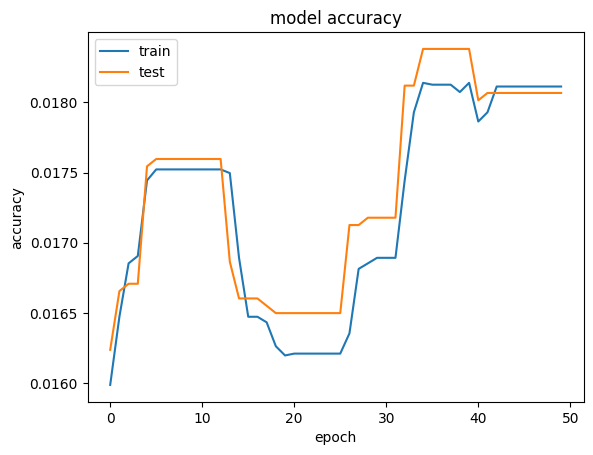

In [10]:
# Plotting accuracy
from matplotlib import pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()